In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import jax.numpy as jnp
import equinox as eqx
from jax import random, jit
from numpyro.distributions import constraints
from scarlet2 import *
import matplotlib.pyplot as plt
import pandas as pd
from scarlet2 import nn
import jax
import cmasher as cmr

/Users/mattsampson/miniconda3/envs/scorenet/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mattsampson/miniconda3/envs/scorenet/lib/python3.9/site-packages/equinox/_ad.py:733: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arra

In [3]:
# plot params
plt.rcParams["xtick.top"] = True 
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.direction"] = 'in' 
plt.rcParams["ytick.direction"] = 'in' 
plt.rcParams["xtick.minor.visible"] = True 
plt.rcParams["ytick.minor.visible"] = True 
plt.rcParams["xtick.major.size"] = 7
plt.rcParams["xtick.minor.size"] = 4.5
plt.rcParams["ytick.major.size"] = 7
plt.rcParams["ytick.minor.size"] = 4.5
plt.rcParams["xtick.major.width"] = 2
plt.rcParams["xtick.minor.width"] = 1.5
plt.rcParams["ytick.major.width"] = 2
plt.rcParams["ytick.minor.width"] = 1.5
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

plt.style.use('dark_background')
cmap = cmr.sepia 
#cmap = 'binary'

In [4]:
# ----------------------------------- #
# grab images from the HSC catalogue  #
# read them into jax arrays and then  #
# make a multi-band image             #
# ----------------------------------- #

# read in the single test galaxy from HSC
data = pd.read_pickle('data_test.pkl')

# for testing other sources
data_name = 'data_HSC_9697_patch_72.pkl' # storing just one patch locally so use it
df = pd.read_pickle(data_name) # 13827 is cool as is 13100
#data = df[df['parent_ID']==df['parent_ID'][13827]] 

# make multi-band data
multi_images = np.array([np.array(data['scene_g'])[0] , np.array(data['scene_r'])[0]  , np.array(data['scene_i'])[0]  , 
                        np.array(data['scene_y'])[0]  , np.array(data['scene_z'])[0] ]) 
multi_var = np.array([np.array(data['var_g'])[0] , np.array(data['var_r'])[0]  , np.array(data['var_i'])[0]  , 
                        np.array(data['var_y'])[0]  , np.array(data['var_z'])[0] ]) 
multi_psf = np.array([np.array(data['PSF_g'])[0] , np.array(data['PSF_r'])[0]  , np.array(data['PSF_i'])[0]  , 
                        np.array(data['PSF_y'])[0]  , np.array(data['PSF_z'])[0] ]) 

images = multi_images 
centers = jnp.asarray( [(src[0], src[1]) for src in data["loc"]] )
box_size = jnp.asarray( [(src) for src in data["box_sz"]] )

frame_psf = GaussianPSF(0.7)
model_frame = Frame(Box(images.shape), psf=frame_psf)

# ----------------------------------- #
#      make one obs per image         #
#    model frame should be the same   #
# ----------------------------------- #
weights = 1/multi_var 
psf = multi_psf
obs = Observation(images, weights, psf=ArrayPSF(jnp.asarray(psf)))
obs.match(model_frame);
print('----------------------------------------')
print(f"    Scene contains {len(centers)} galaxy sources")
print('----------------------------------------')

----------------------------------------
    Scene contains 6 galaxy sources
----------------------------------------


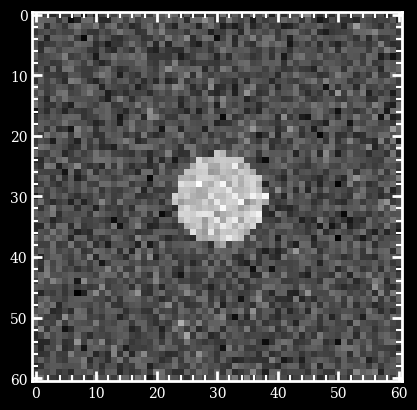

In [5]:
# define initial circular model for initial morphology estimate 
from skimage import draw

# empty list
morph_init = [None]*len(centers)
scarlet1_init = [None]*len(centers)
key = random.split(random.PRNGKey(0), 1)
sigma = .2 # noise factor

for i, bx in enumerate(box_size):
    arr = np.zeros((bx, bx))
    rr, cc = draw.disk((bx/2, bx/2), radius=bx/8, shape=arr.shape)
    arr[rr, cc] = 1
    noise = random.normal(key, (box_size[i], box_size[i]))
    raw =  arr + sigma * noise 
    #raw = sigma + noise
    normed = (raw-jnp.min(raw))/(jnp.max(raw)-jnp.min(raw)) 
    morph_init[i] = normed
    
    # add scarlet initialisation, use i-band here for no significant reason
    scarlet1_init[i] = np.array([np.array(data['scar_i'])[i] ])[0]

plt.imshow(morph_init[0], cmap='gray')

In [6]:
# Load up the Scene with constraints and prior selected (no prior here)
keys = random.split(random.PRNGKey(0), 2)
with Scene(model_frame) as scene:
    for i in range(len( centers )):
        Source(
            centers[i],
            ArraySpectrum(Parameter(jnp.ones(5), 
                                    constraint=constraints.positive, 
                                    stepsize=5e-1)),
            ArrayMorphology(Parameter(morph_init[i], 
                                    constraint=constraints.positive,
                                    stepsize=2e-1))
            #ArrayMorphology(Parameter(scarlet1_init[i], stepsize=1e-1))
        )
        
# now fit the model
scene_lik= scene.fit(obs, max_iter=175, e_rel=1e-4)

100%|██████████| 175/175 [00:01<00:00, 168.43it/s, loss=-22359.53]


In [7]:
# make a poor stretching routine for better visuals
# TODO: Make proper normalising and stretching routine like the Lupton one
from astropy.visualization.stretch import SinhStretch, LinearStretch
from astropy.visualization import ImageNormalize
stretch = LinearStretch(slope=0.5, intercept=0.5) + SinhStretch() + \
    LinearStretch(slope=1, intercept=-1)
norm = ImageNormalize(stretch=stretch, vmin=0, vmax=2)
int_method='none'

# make renders
renders_lik = obs.render(scene_lik())

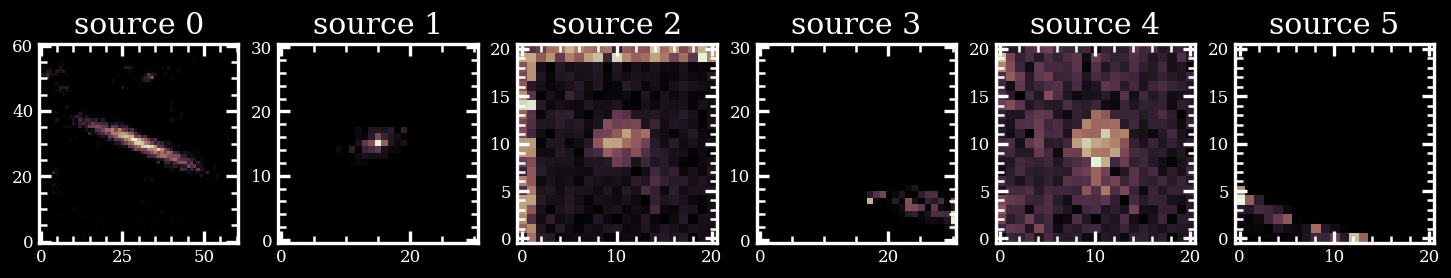

<Figure size 640x480 with 0 Axes>

In [8]:
# These should look bad with a random noise initialisation
fig, axes = plt.subplots(1, len( scene_lik.sources ), figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    y = scene_lik.sources[i].morphology() 
    ax.imshow(y, cmap = cmap, vmin=0, interpolation=int_method) # set to 0 until Matt fixes issue
    ax.set_title(f"source {i}", fontsize = 18)
    ax.invert_yaxis()
#plt.suptitle('reconstructed sources', fontsize=24,y=0.75)
plt.show()
plt.clf()

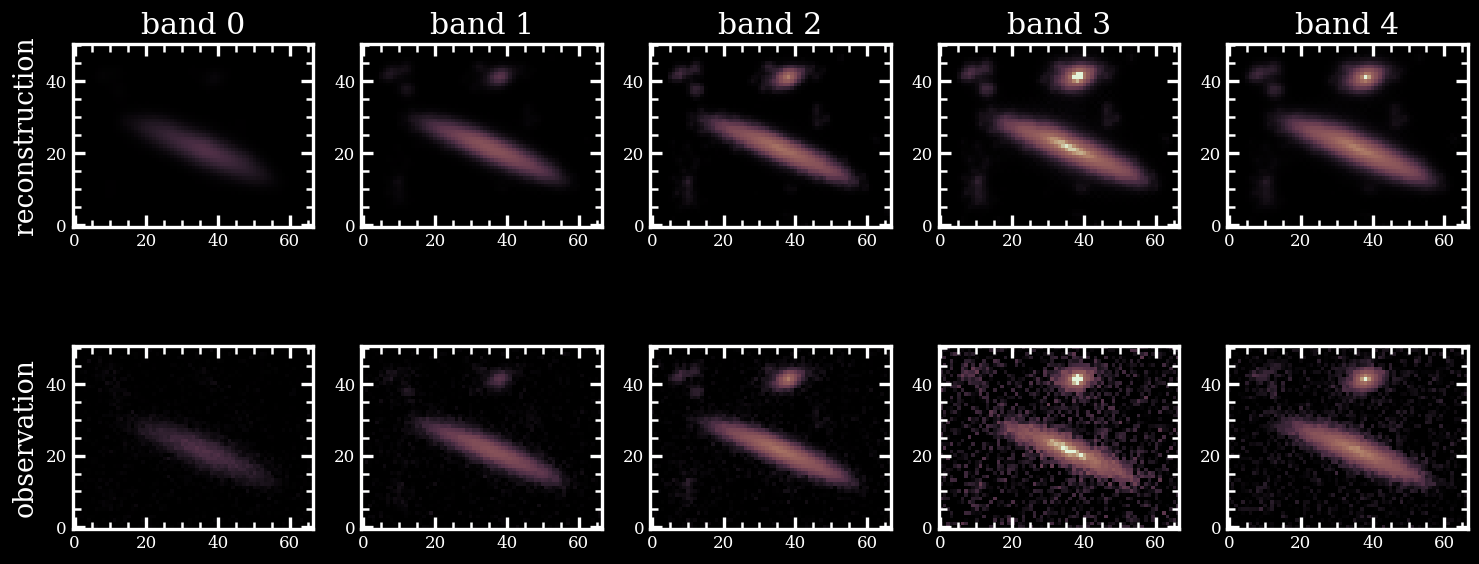

<Figure size 640x480 with 0 Axes>

In [9]:
fig, axes = plt.subplots(2, len( renders_lik ), figsize=(15,6),dpi=120)
renders_log = renders_lik
for i in range( len(renders_lik) ):
    y = renders_log[i]
    axes[0][i].imshow(y, cmap = cmap,norm=norm,interpolation=int_method)
    axes[0][i].set_title(f"band {i}", fontsize = 18)
    axes[0][i].invert_yaxis()
    
    # now plot the observations
    axes[1][i].imshow(obs.data[i], cmap = cmap,norm=norm, interpolation=int_method)
    axes[1][i].invert_yaxis()
    
axes[0][0].set_ylabel('reconstruction', fontsize=16)
axes[1][0].set_ylabel('observation', fontsize=16)
plt.show()
plt.clf()

In [10]:
# Load up the Scene with constraints and prior selected
keys = random.split(random.PRNGKey(0), 2)
with Scene(model_frame) as scene1:
    for i in range(len( centers )):
        # define new prior here for each new model
        prior = nn.NNPrior(trained_model='hsc', log_space=False, shape=jnp.shape(morph_init[i]))
        Source(
            centers[i],
            ArraySpectrum(Parameter(jnp.ones(5), 
                                    constraint=constraints.positive, 
                                    stepsize=5e-2)),
            ArrayMorphology(Parameter(morph_init[i], 
                                    prior=prior, 
                                    constraint=constraints.positive, 
                                    stepsize=5e-2))
            # ArrayMorphology(Parameter(scarlet1_init[i], 
            #                         prior=prior, 
            #                         #constraint=constraints.positive, 
            #                         stepsize=1e-1))
        )
        
# now fit the model
scene_prior = scene1.fit(obs, max_iter=100, e_rel=1e-4)
renders_prior = obs.render(scene_prior())

100%|██████████| 100/100 [00:09<00:00, 10.61it/s, loss=-21081.45]


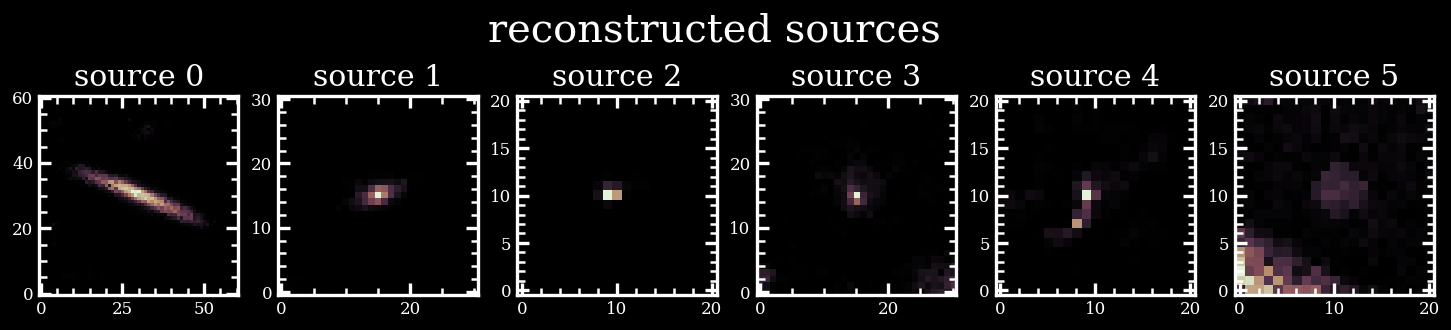

<Figure size 640x480 with 0 Axes>

In [11]:
# These should look far more like actual galaxies with the neural network acting as a constraint
fig, axes = plt.subplots(1, len( scene_prior.sources ), figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    y = scene_prior.sources[i].morphology() 
    ax.imshow(y, cmap = cmap, vmin=0, interpolation=int_method) 
    ax.set_title(f"source {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('reconstructed sources', fontsize=24,y=0.75)
plt.show()
plt.clf()

# Lets take a look at the differences

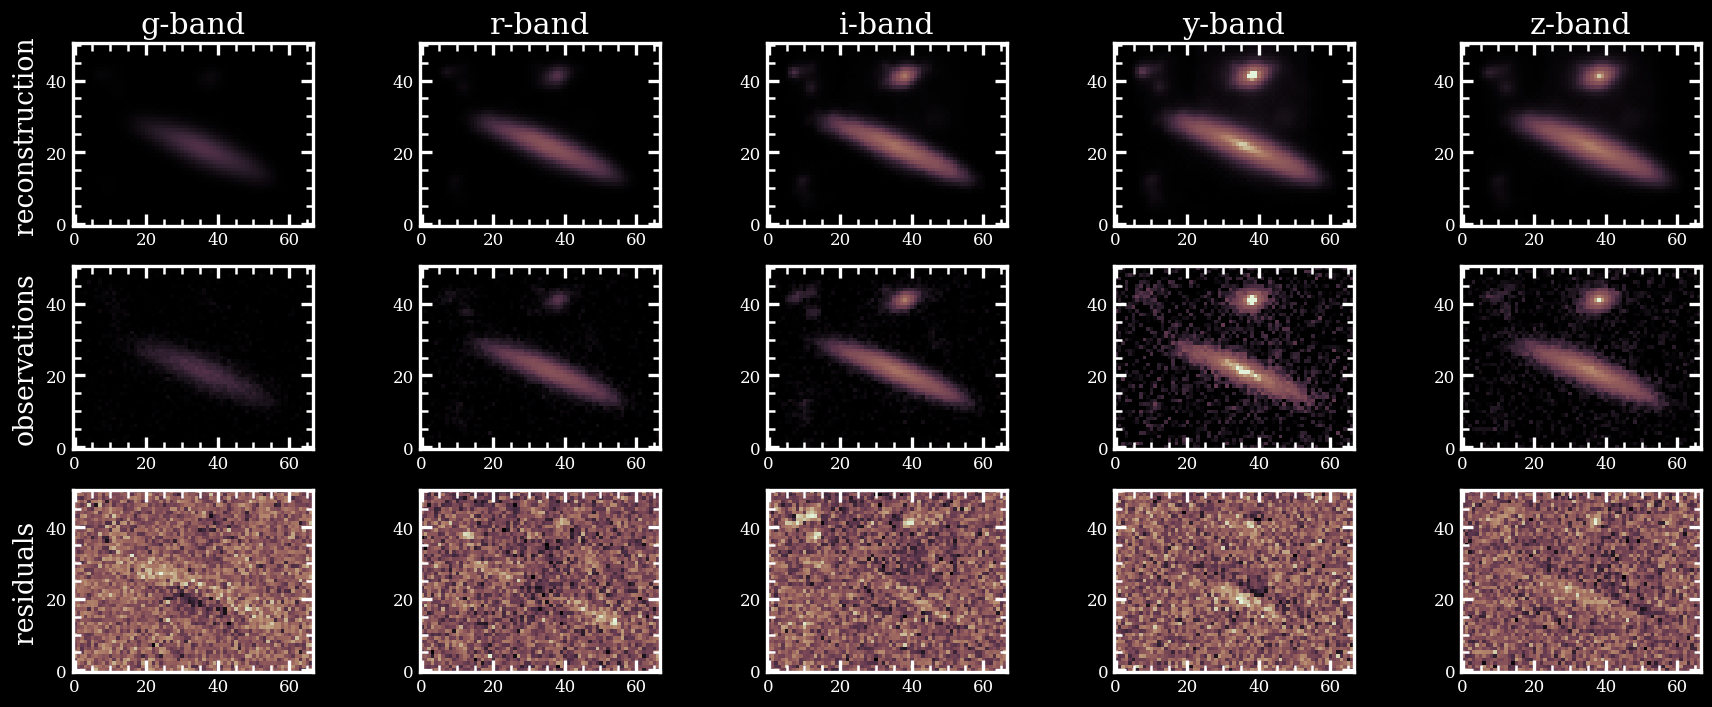

<Figure size 640x480 with 0 Axes>

In [12]:
fig, axes = plt.subplots(3, len( renders_prior ), figsize=(15,6),dpi=120)
band_list = ['g-band', 'r-band', 'i-band', 'y-band', 'z-band']
for i in range( len(renders_prior) ):

    # with neural network
    y2 = renders_prior[i]
    axes[0][i].imshow(y2, cmap = cmap,norm=norm,interpolation=int_method)
    axes[0][i].invert_yaxis()
    axes[0][i].set_title(band_list[i], fontsize = 18)

    # now plot the observations
    axes[1][i].imshow(obs.data[i], cmap = cmap,norm=norm, interpolation=int_method)
    axes[1][i].invert_yaxis()
    
    # the residuals
    axes[2][i].imshow(obs.data[i] - y2, cmap = cmap)#'Greys')
    axes[2][i].invert_yaxis()
    
axes[0][0].set_ylabel('reconstruction', fontsize=16)
axes[1][0].set_ylabel('observations', fontsize=16)
axes[2][0].set_ylabel('residuals', fontsize=16)

fig.tight_layout()
plt.savefig('residuals.pdf', dpi=120)
plt.show()
plt.clf()